# EfficientNetB0 ＋ LSTM

## アーキテクチャの説明

batch_sizeを64にした場合

入力画像はi-1,i,i+1の３連続フレームをＲＧＢにしたスタック画像を10batchにする[64, 10, 3, 128, 128]

CNNでの出力は[64, 10, 1280, 4, 4]

avaragepoolingで[64, 10, 1280, 1, 1]に圧縮

reshapeで[64, 10, 1280]に変形 (batch, seq_len, input_size)

LSTMでseqence間をつなげて[64, 10, 128]に出力（隠れ状態変数を128にした）

LSTMの最後のseq部分[64, 1, 128]を入力としてLinearで([64, 1])で出力

CNNから出力される特徴量はB0では1280、B4では1789、B7では2560

### 実装の工夫
１つの動画のデータサイズが大きくて一度に全ての動画がメインメモリに載り切らないため、
一度データをnpzファイルにして保存してロードして使うようにした

前処理として、動画の平均画像の差分をとり、さらに移動平均を引いたものを入力とした

前処理をmini-maxからnormalizeに変更した

まずstage1でＣＮＮだけを学習させる

必要ならstage2ではＣＮＮのパラメータを固定しない

reshape時に順序が整うように、LSTMのbatch_first=Trueにした

scheduler.CosineAnnealingLRで学習率を変動させた

## メモ

CNNのパラメータ固定と２エポックで
Mean Accuracy:0.9002342852909582

CNNのパラメータ固定なしと２エポックで
Mean Accuracy:0.9003176278845798

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Preprocessing

In [2]:
import tifffile
def load_image(filename):
    raw_image = tifffile.imread(filename)
    image1 = raw_image - raw_image.mean(axis=0)
    
    f_size=1000
    filter_ = np.ones(f_size)/f_size
    movemean = np.apply_along_axis(lambda m: np.convolve(m, filter_, mode='same'), axis=0, arr=image1) 
    image =  image1 - movemean
    
    ax = image.shape
    X_tmp = (image - image.mean()) / image.std() # Normalize
    #X_tmp = (image - image.min()) / (image.max() - image.min()) # MINI-MAX
    X = np.zeros([ax[0] - 2, 3, ax[1], ax[2]])
    X[:,0,:,:] = X_tmp[:-2, :, :]
    X[:,1,:,:] = X_tmp[1:-1, :, :]
    X[:,2,:,:] = X_tmp[2:, :, :]
    return X

In [3]:
FRAME_NUM = 18000 #動画のフレームの長さ
THR = 0.5 #runしているかどうかの判別の閾値

def load_label(filename):
    behave = pd.read_table(filename)
    Y = np.zeros([FRAME_NUM - 2, 1])
    for i in range(FRAME_NUM - 2):
        Speed = np.asarray(behave.Speed)
        idx = np.abs(np.asarray(behave.Frame) - (i+2)).argmin() # nearest value index
        Y[i,:] = Speed[idx] > THR
    print('positive proportion: {:.2}'.format(Y.sum() / FRAME_NUM))
    return Y

In [4]:
import glob
folder = 'data/'
data_tmp = glob.glob(folder + '*.tif')
data = []
for i in data_tmp:
    a = i.lstrip(folder).rstrip('.tif')
    data.append(a)

In [5]:
# 前半の半分をtraining、その後の1/4をvalidation、残りをinference
print(len(data))
train_len = len(data)//2
print(train_len)
valid_len = len(data)//2 + len(data)//4
print(valid_len)

43
21
31


In [6]:
# データ振り分け
train_data = data[:train_len]
print(train_data)
valid_data = data[train_len:valid_len]
print(valid_data)
infer_data = data[valid_len:]
print(infer_data)

['20180206_Emx1G6_non_1', '20180208_Emx1G6_non_1', '20180216_Emx1G6_R_1', '20180126_Emx1G6_LR_1', '20180207_Emx1G6_R_1', '20180201_Emx1G6_LR_1', '20180205_Emx1G6_R_1', '20180131_Emx1G6_R_1', '20180215_Emx1G6_LR_1', '20180131_Emx1G6_LR_1', '20180126_Emx1G6_R_1', '20180209_Emx1G6_R_1', '20180125_Emx1G6_non_1', '20180129_Emx1G6_non_1', '20180130_Emx1G6_R_1', '20180209_Emx1G6_LR_1', '20180214_Emx1G6_R_1', '20180215_Emx1G6_R_1', '20180130_Emx1G6_non_1', '20180208_Emx1G6_LR_1', '20180213_Emx1G6_R_1']
['20180207_Emx1G6_non_1', '20180130_Emx1G6_LR_1', '20180214_Emx1G6_non_1', '20180213_Emx1G6_LR_1', '20180207_Emx1G6_LR_1', '20180214_Emx1G6_LR_1', '20180216_Emx1G6_non_1', '20180206_Emx1G6_LR_1', '20180131_Emx1G6_non_1', '20180129_Emx1G6_R_1']
['20180216_Emx1G6_LR_1', '20180125_Emx1G6_R_1', '20180126_Emx1G6_non_1', '20180206_Emx1G6_R_1', '20180125_Emx1G6_LR_1', '20180213_Emx1G6_non_1', '20180208_Emx1G6_R_1', '20180209_Emx1G6_non_1', '20180129_Emx1G6_LR_1', '20180201_Emx1G6_non_1', '20180215_Emx1

In [7]:
SEQ_SIZE = 10
import gc
def save_npz_train():
    for i in train_data:
        print(i)
        X = load_image(folder + i + '.tif')
        Y = load_label(folder + i +'.txt')
        for j in range(len(Y) - SEQ_SIZE):
            x = X[j:j+SEQ_SIZE,:,:,:]
            y = Y[j+SEQ_SIZE,:]
            np.savez(f'npz_stage2/train/{i}_{j}',x,y)
        del X, Y
        gc.collect();
        
def save_npz_valid():
    for i in valid_data:
        print(i)
        X = load_image(folder + i + '.tif')
        Y = load_label(folder + i +'.txt')
        for j in range(len(Y) - SEQ_SIZE):
            x = X[j:j+SEQ_SIZE,:,:,:]
            y = Y[j+SEQ_SIZE,:]
            np.savez(f'npz_stage2/valid/{i}_{j}',x,y)
        del X, Y
        gc.collect();

In [8]:
save_npz_train()

20180206_Emx1G6_non_1
positive proportion: 0.82
20180208_Emx1G6_non_1
positive proportion: 0.78
20180216_Emx1G6_R_1
positive proportion: 0.4
20180126_Emx1G6_LR_1
positive proportion: 0.37
20180207_Emx1G6_R_1
positive proportion: 0.53
20180201_Emx1G6_LR_1
positive proportion: 0.38
20180205_Emx1G6_R_1
positive proportion: 0.61
20180131_Emx1G6_R_1
positive proportion: 0.72
20180215_Emx1G6_LR_1
positive proportion: 0.046
20180131_Emx1G6_LR_1
positive proportion: 0.29
20180126_Emx1G6_R_1
positive proportion: 0.82
20180209_Emx1G6_R_1
positive proportion: 0.58
20180125_Emx1G6_non_1
positive proportion: 0.42
20180129_Emx1G6_non_1
positive proportion: 0.38
20180130_Emx1G6_R_1
positive proportion: 0.69
20180209_Emx1G6_LR_1
positive proportion: 0.21
20180214_Emx1G6_R_1
positive proportion: 0.41
20180215_Emx1G6_R_1
positive proportion: 0.45
20180130_Emx1G6_non_1
positive proportion: 0.84
20180208_Emx1G6_LR_1
positive proportion: 0.2
20180213_Emx1G6_R_1
positive proportion: 0.47


In [9]:
save_npz_valid()

20180207_Emx1G6_non_1
positive proportion: 0.81
20180130_Emx1G6_LR_1
positive proportion: 0.4
20180214_Emx1G6_non_1
positive proportion: 0.75
20180213_Emx1G6_LR_1
positive proportion: 0.27
20180207_Emx1G6_LR_1
positive proportion: 0.33
20180214_Emx1G6_LR_1
positive proportion: 0.14
20180216_Emx1G6_non_1
positive proportion: 0.34
20180206_Emx1G6_LR_1
positive proportion: 0.22
20180131_Emx1G6_non_1
positive proportion: 0.81
20180129_Emx1G6_R_1
positive proportion: 0.73


# Training

In [10]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [11]:
# seed固定
import os, random
SEED = 2020
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

In [12]:
VER = 'b0'
from efficientnet_pytorch import EfficientNet
cnn = EfficientNet.from_pretrained('efficientnet-'+VER, num_classes=1)
cnn.load_state_dict(torch.load("models/cnn_best_{}.pth".format(VER)))

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [13]:
# cnn のパラメータを固定
for param in cnn.parameters():
    param.requires_grad = False

In [14]:
BATCH_SIZE = 64
SEQ_SIZE = 10
FEATURE_SIZE = 1280 # efficient-net b0の時は1280
LSTM_UNITS = 128

class CNN_LSTM(nn.Module):
    def __init__(self,cnn):
        super(CNN_LSTM, self).__init__()
        self.cnn = cnn.cuda()
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.lstm = nn.LSTM(FEATURE_SIZE, LSTM_UNITS, num_layers=2, dropout=0.2, batch_first=True)
        self.linear_out = nn.Linear(LSTM_UNITS, 1)

    def forward(self, x):
        x = x.reshape(-1, 3, x.shape[3], x.shape[4]) # (batch, channel, size1, size2)
        with torch.no_grad():
            embedding = self.cnn.extract_features(x)
            embedding = self.avgpool(embedding)
            embedding = embedding.reshape(-1, SEQ_SIZE, FEATURE_SIZE) # (batch, seq_len, input_size)
        self.lstm.flatten_parameters()
        o_lstm, _ = self.lstm(embedding)
        output = self.linear_out(o_lstm[:,-1,:])
        return output

In [15]:
model = CNN_LSTM(cnn)
model.cuda()

CNN_LSTM(
  (cnn): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project

In [16]:
# parameter数をカウント
params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
print(params) 

854145


In [17]:
from tqdm.auto import tqdm
class trainer:
    def __init__(self):
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.model = model
        self.lr = 1e-3
        self.optimizer = torch.optim.Adam(model.parameters(), lr=self.lr) 
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=100, eta_min=self.lr * 0.1)
        
    def batch_train(self, batch_imgs, batch_labels, batch_idx):
        batch_imgs, batch_labels = batch_imgs.cuda().float(), batch_labels.cuda().float()
        predicted = self.model(batch_imgs)
        loss = self.loss_fn(predicted.float().reshape(-1), batch_labels.reshape(-1))
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item(), predicted
    
    def train_epoch(self, loader):
        self.model.train()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
            loss, predicted = self.batch_train(imgs, labels, batch_idx)
            current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
            tqdm_loader.set_description('loss: {:.4} lr:{:.6}'.format(current_loss_mean, self.optimizer.param_groups[0]['lr']))
            self.scheduler.step()
        return current_loss_mean
    
    def valid_epoch(self, loader):
        self.model.eval()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        current_accuracy_mean = 0
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
            with torch.no_grad():
                batch_imgs = imgs.cuda().float()
                batch_labels = labels.cuda().float()
                predicted = self.model(batch_imgs)
                loss = self.loss_fn(predicted.float().reshape(-1),batch_labels.float().reshape(-1)).item()
                current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
                output = (torch.sigmoid(predicted)>0.5).float()
                accuracy = (output == batch_labels).float().mean()
                current_accuracy_mean = (current_accuracy_mean * batch_idx + accuracy) / (batch_idx + 1)
                tqdm_loader.set_description('loss: {:.4} acc:{:.4}'.format(current_loss_mean, current_accuracy_mean))
        return current_loss_mean
        
    def predict(self, batch_imgs):
        self.model.eval()
        batch_imgs = batch_imgs.cuda().float()
        with torch.no_grad():
            predicted = self.model(batch_imgs)
        return torch.sigmoid(predicted)

In [18]:
class ImageLoadDataset:
    def __init__(self, foldername):
        self.folder = glob.glob(foldername + '*.npz')
        
    def __len__(self):
        return (len(self.folder))
    
    def __getitem__(self, idx):
        xy_data = np.load(self.folder[idx])
        x = torch.tensor(xy_data['arr_0'], dtype=torch.float)
        y = torch.tensor(xy_data['arr_1'], dtype=torch.float)            
        return x, y

In [19]:
from torch.utils.data import DataLoader
Trainer = trainer()

def training():
    ds_t = ImageLoadDataset('npz_stage2/train/')
    train = DataLoader(ds_t, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=False)
    loss = Trainer.train_epoch(train)
    print('train loss {}'.format(loss))
    return loss

def validation():
    ds_v = ImageLoadDataset('npz_stage2/valid/')
    val = DataLoader(ds_v, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=False)
    loss = Trainer.valid_epoch(val)
    print('valid loss {}'.format(loss))
    return loss

In [20]:
# RUN
best_loss = np.inf
EPOCH = 3
score = np.zeros([EPOCH,2])
for i in range(EPOCH):
    print("----------Epoch {}-----------".format(i))
    score[i,0] = training()
    score[i,1] = validation()
    loss = score[i,1]
    if best_loss > loss:
        best_loss = loss
        torch.save(Trainer.model.state_dict(),"models/cnn_lstm_best_{}.pth".format(VER))
        print("save best model")

----------Epoch 0-----------



train loss 0.2541607123044375



valid loss 0.3100285479068035
save best model
----------Epoch 1-----------



train loss 0.24914395047959775



valid loss 0.3027936496378604
save best model
----------Epoch 2-----------



train loss 0.24776305582272729



valid loss 0.3040132694017928


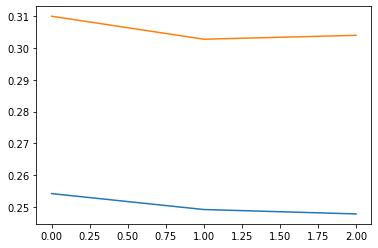

In [21]:
# plot result
plt.plot(score)

# Inference

In [22]:
Trainer.model.load_state_dict(torch.load("models/cnn_lstm_best_{}.pth".format(VER)))

<All keys matched successfully>

In [23]:
class ImageDataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0] - SEQ_SIZE)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx:idx+SEQ_SIZE, :, :, :], dtype=torch.float)
        y = torch.tensor(self.targets[idx+SEQ_SIZE, :], dtype=torch.float)            
        return x, y

In [24]:
def inference_1_image(filename):
    Y_pred = np.zeros([FRAME_NUM-2, 1])
    Y_true = np.zeros([FRAME_NUM-2, 1])
    X = load_image(folder + filename + '.tif')
    Y = load_label(folder + filename +'.txt')
    ds_i = ImageDataset(X, Y)
    infe = DataLoader(ds_i, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=False)
    tqdm_loader = tqdm(infe)
    for idx, (imgs,labels) in enumerate(tqdm_loader):
        bs = labels.shape[0]
        Y_pred[idx*bs:(idx+1)*bs] = Trainer.predict(imgs).cpu()
        Y_true[idx*bs:(idx+1)*bs] = labels
    del X, Y, ds_i, infe, tqdm_loader
    gc.collect();
    return Y_pred, Y_true

In [25]:
def calculate_accuracy():
    acc = np.zeros(len(infer_data))
    for i, file in enumerate(infer_data):
        print(file)
        Y_pred, Y_true = inference_1_image(file)
        output = Y_pred > 0.5
        accuracy = (output == Y_true).mean()
        print('Accuracy:{}'.format(accuracy))
        acc[i] = accuracy
    print('Mean Accuracy:{}'.format(acc.mean()))

In [26]:
calculate_accuracy()

20180216_Emx1G6_LR_1
positive proportion: 0.035



Accuracy:0.9431603511501278
20180125_Emx1G6_R_1
positive proportion: 0.76



Accuracy:0.9421602400266696
20180126_Emx1G6_non_1
positive proportion: 0.26



Accuracy:0.9006000666740749
20180206_Emx1G6_R_1
positive proportion: 0.61



Accuracy:0.9127680853428158
20180125_Emx1G6_LR_1
positive proportion: 0.34



Accuracy:0.8721524613845983
20180213_Emx1G6_non_1
positive proportion: 0.83



Accuracy:0.8675963995999556
20180208_Emx1G6_R_1
positive proportion: 0.38



Accuracy:0.9018779864429382
20180209_Emx1G6_non_1
positive proportion: 0.71



Accuracy:0.9315479497721969
20180129_Emx1G6_LR_1
positive proportion: 0.32



Accuracy:0.8682631403489277
20180201_Emx1G6_non_1
positive proportion: 0.75



Accuracy:0.8851539059895543
20180215_Emx1G6_non_1
positive proportion: 0.45



Accuracy:0.9111012334703856
20180201_Emx1G6_R_1
positive proportion: 0.7



Accuracy:0.8674297144127125
Mean Accuracy:0.9003176278845798


In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

def inference():
    Y_pred_all = np.zeros([(FRAME_NUM-2)*len(infer_data), 1])
    Y_true_all = np.zeros([(FRAME_NUM-2)*len(infer_data), 1])
    for i, file in enumerate(infer_data):
        print(file)
        Y_pred, Y_true = inference_1_image(file)
        Y_pred_all[i*(FRAME_NUM-2):(i+1)*(FRAME_NUM-2), 0] = Y_pred[:,0]
        Y_true_all[i*(FRAME_NUM-2):(i+1)*(FRAME_NUM-2), 0] = Y_true[:,0]
        plt.plot(Y_true, label="grand truth")
        plt.plot(Y_pred, label="prediction")
        plt.legend()
        plt.show()
        fpr, tpr, thresholds = roc_curve(Y_true, Y_pred, pos_label=1)
        AUC = roc_auc_score(Y_true, Y_pred)
        plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
        plt.title("ROC curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()
        print('AUCは')
        print(auc(fpr, tpr))
        print('です。')
        print('最適な閾値は')
        opt_thr = thresholds[np.argmax(tpr - fpr)]
        print(opt_thr)
        print('です。')
        plt.plot(Y_true, label="grand truth")
        plt.plot(Y_pred > opt_thr, label="prediction")
        plt.title("Optimal threshold")
        plt.legend()
        plt.show()
        del Y_pred, Y_true
        gc.collect();
    return Y_pred_all, Y_true_all

20180216_Emx1G6_LR_1
positive proportion: 0.035


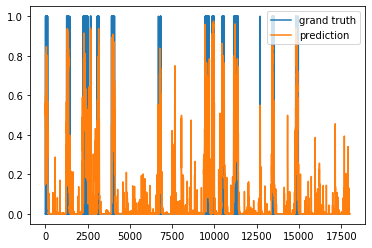

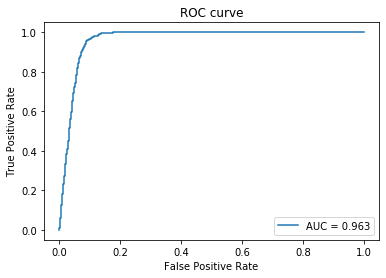

AUCは
0.9627201749841708
です。
最適な閾値は
0.25122448801994324
です。


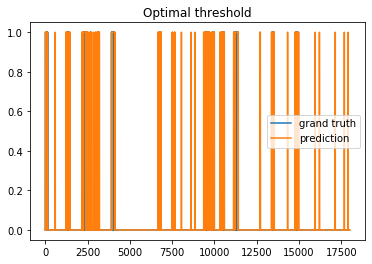

20180125_Emx1G6_R_1
positive proportion: 0.76


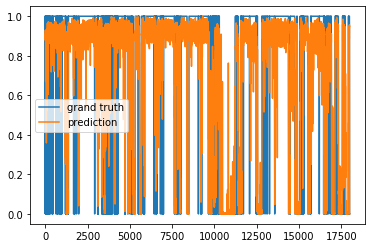

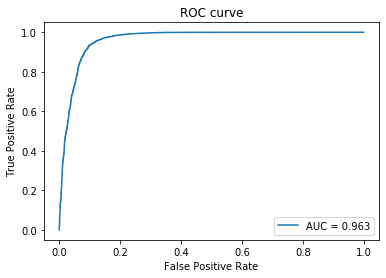

AUCは
0.9627130338075957
です。
最適な閾値は
0.7713057994842529
です。


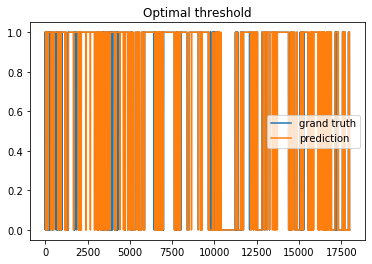

20180126_Emx1G6_non_1
positive proportion: 0.26


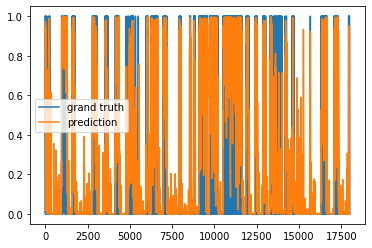

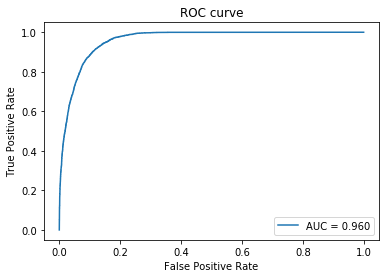

AUCは
0.960494697983252
です。
最適な閾値は
0.22058840095996857
です。


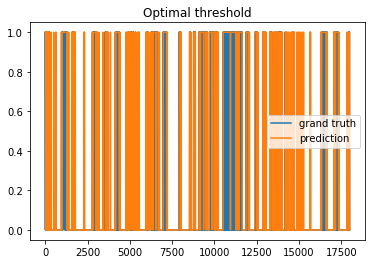

20180206_Emx1G6_R_1
positive proportion: 0.61


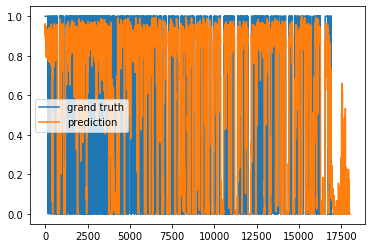

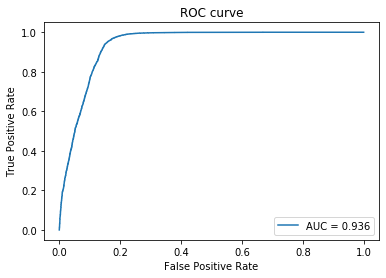

AUCは
0.9361577650900789
です。
最適な閾値は
0.559147834777832
です。


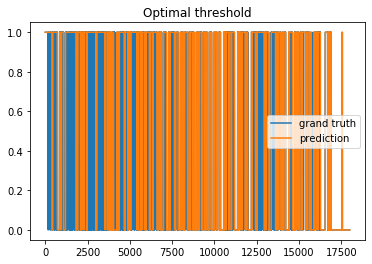

20180125_Emx1G6_LR_1
positive proportion: 0.34


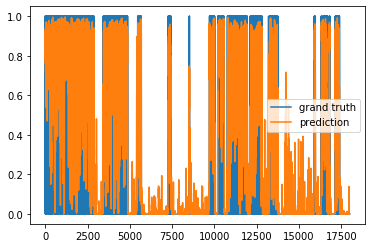

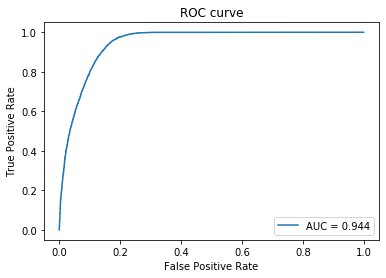

AUCは
0.9444597070259223
です。
最適な閾値は
0.23706035315990448
です。


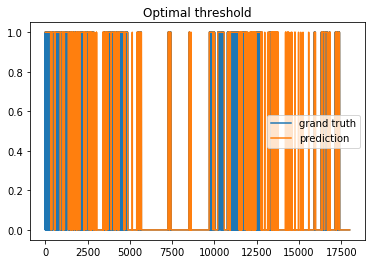

20180213_Emx1G6_non_1
positive proportion: 0.83


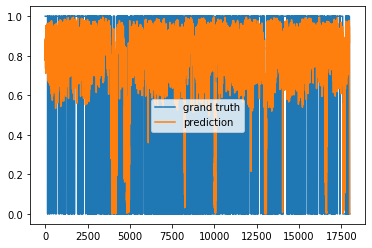

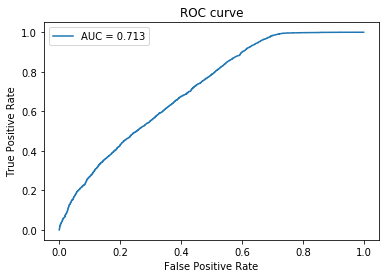

AUCは
0.7130077395412867
です。
最適な閾値は
0.7106814980506897
です。


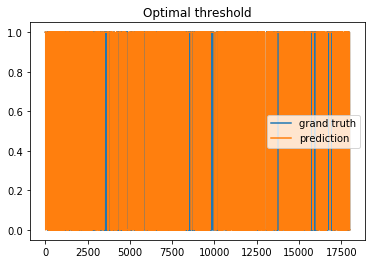

20180208_Emx1G6_R_1
positive proportion: 0.38


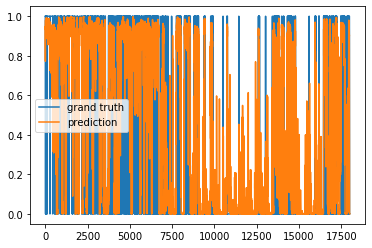

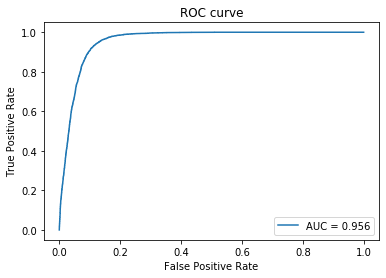

AUCは
0.9562538246689597
です。
最適な閾値は
0.43233218789100647
です。


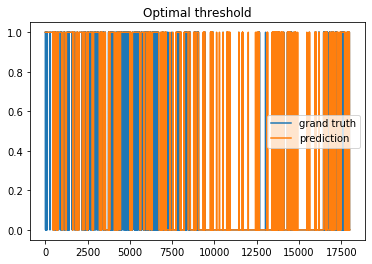

20180209_Emx1G6_non_1
positive proportion: 0.71


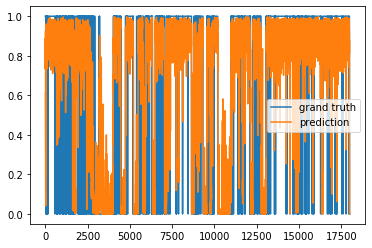

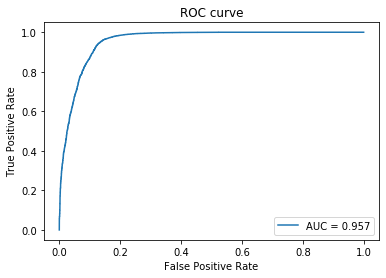

AUCは
0.9566388987729301
です。
最適な閾値は
0.6872981786727905
です。


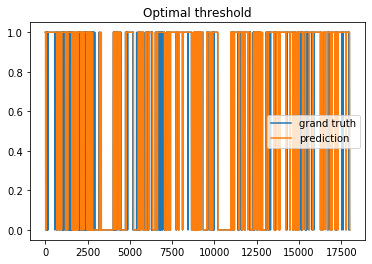

20180129_Emx1G6_LR_1
positive proportion: 0.32


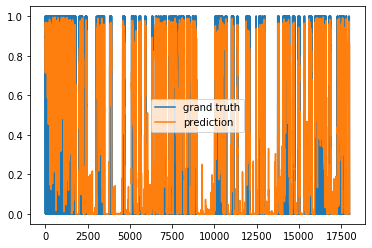

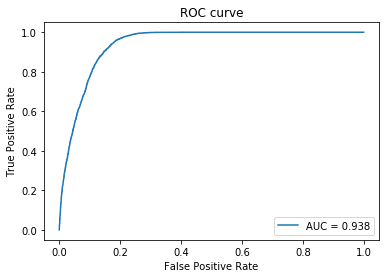

AUCは
0.9383200598463738
です。
最適な閾値は
0.29633834958076477
です。


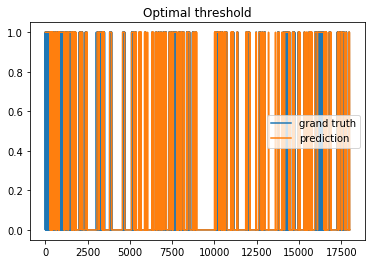

20180201_Emx1G6_non_1
positive proportion: 0.75


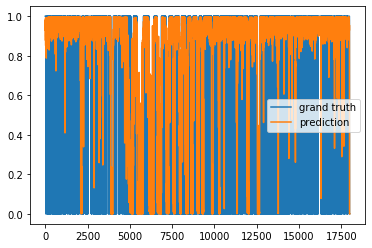

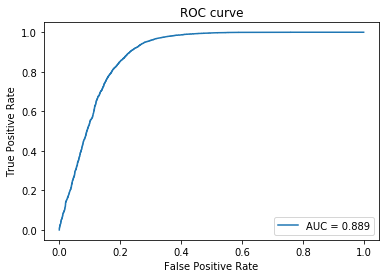

AUCは
0.8891199820303183
です。
最適な閾値は
0.8890010118484497
です。


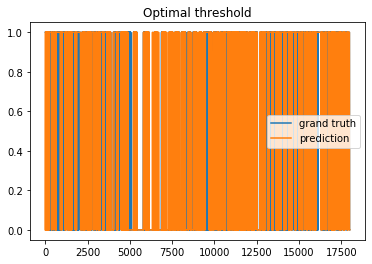

20180215_Emx1G6_non_1
positive proportion: 0.45


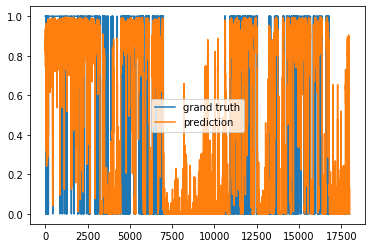

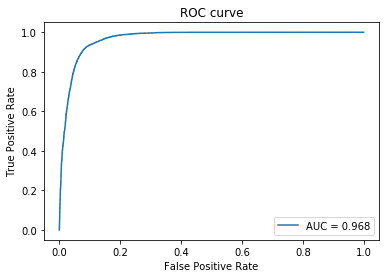

AUCは
0.9683389951774468
です。
最適な閾値は
0.6367859244346619
です。


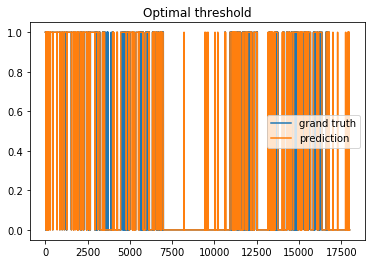

20180201_Emx1G6_R_1
positive proportion: 0.7


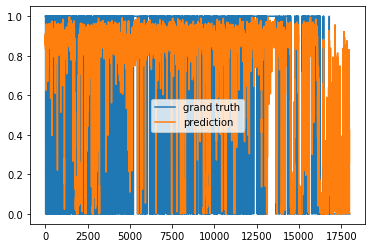

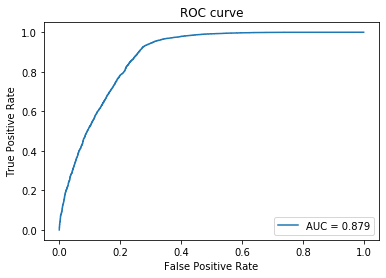

AUCは
0.8793133594363712
です。
最適な閾値は
0.7992809414863586
です。


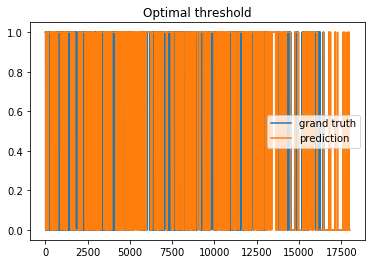

In [28]:
Y_pred, Y_true = inference()

In [29]:
output = Y_pred > 0.5
accuracy = (output == Y_true).mean()
print('Accuracy:{}'.format(accuracy))

Accuracy:0.9003176278845798


/home/takehiro/anaconda3/envs/kaggle/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


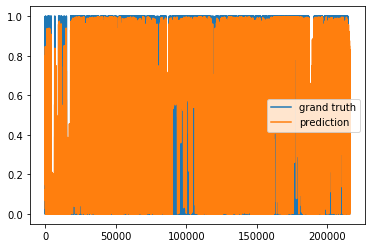

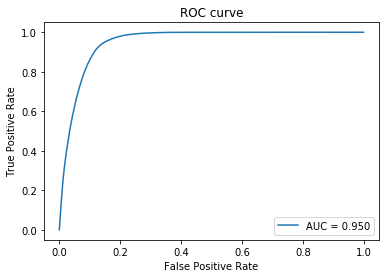

AUCは
0.9499151550208682
です。
最適な閾値は
0.5766795873641968
です。


/home/takehiro/anaconda3/envs/kaggle/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


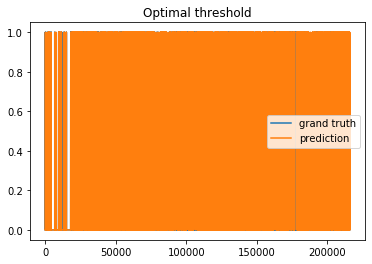

In [30]:
plt.plot(Y_true, label="grand truth")
plt.plot(Y_pred, label="prediction")
plt.legend()
plt.show()
fpr, tpr, thresholds = roc_curve(Y_true, Y_pred, pos_label=1)
AUC = roc_auc_score(Y_true, Y_pred)
plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
print('AUCは')
print(auc(fpr, tpr))
print('です。')
print('最適な閾値は')
opt_thr = thresholds[np.argmax(tpr - fpr)]
print(opt_thr)
print('です。')
plt.plot(Y_true, label="grand truth")
plt.plot(Y_pred > opt_thr, label="prediction")
plt.title("Optimal threshold")
plt.legend()
plt.show()